In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects # type: ignore
import matplotlib.font_manager as fm
import matplotlib.colors as mcolors
from matplotlib import cm
from highlight_text import fig_text, ax_text
from matplotlib.patches import RegularPolygon
import requests
import json
import numpy as np

# We'll only use a vertical pitch for this tutorial
from mplsoccer import VerticalPitch

from PIL import Image
import urllib
import os

font_path = "C:/Users/Federico Rábanos/Documents/lanus stats/Python/LigaArgStats/assets/fonts"
for x in os.listdir(font_path):
    for y in os.listdir(f"{font_path}/{x}"):
        if y.split(".")[-1] == "otf":
            fm.fontManager.addfont(f"{font_path}/{x}/{y}")
            try:
                fm.FontProperties(weight=y.split("-")[-1].split(".")[0].lower(), fname=y.split("-")[0])
            except Exception:
                continue

plt.style.use("C:/Users/Federico Rábanos/Documents/lanus stats/Python/LigaArgStats/assets/stylesheets/soc_base.mplstyle")
plt.rcParams['font.family'] = 'Nippo'

In [2]:
colors = [
    '#d0d6d4',
    '#c5d0cd',
    '#bbcac7',
    '#b0c3c1',
    '#a6bdbb',
    '#9bb7b5',
    '#91b1af',
    '#86aaa8',
    '#7ca4a2',
    '#719e9c',
    '#679896',
    '#5c9190',
    '#528b8a',
    '#478583',
    '#3d7f7d',
    '#327877',
    '#287271',
]
soc_cm = mcolors.LinearSegmentedColormap.from_list('SOC', colors, N=50)
cm.register_cmap(name='SOC', cmap=soc_cm)

# function for semicircle
def semicircle(r, h, k):
    x0 = h - r  # determine x start
    x1 = h + r  # determine x finish
    x = np.linspace(x0, x1, 10000)  # many points to solve for y

    # use numpy for array solving of the semicircle equation
    y = k - np.sqrt(r**2 - (x - h)**2)  
    return x, y

<ipython-input-2-018942aac90f>:21: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  cm.register_cmap(name='SOC', cmap=soc_cm)


In [3]:
def get_player_season_shotmap(id):
    response = requests.get(f'https://www.fotmob.com/api/playerStats?playerId={id}&seasonId=2024-10007')
    shotmap = pd.DataFrame(response.json()['shotmap'])
    return shotmap

In [24]:
def plot_hexbin_shot(ax, id):

    df = get_player_season_shotmap(id)

    data = df[['eventType', 'playerName', 'x', 'y', 'expectedGoals', 'teamId', 'teamColor', 'teamColorDark', 'teamId']]
    pitch = VerticalPitch(
        pitch_type='custom',
        half=True,
        goal_type='box',
        linewidth=1.25,
        line_color='black',
        pad_bottom=-8,
        pad_top=10,
        pitch_length=105,
        pitch_width=68
    )
    pitch.draw(ax = ax)

    bins = pitch.hexbin(x=data['x'], y=data['y'], ax=ax, cmap='SOC', gridsize=(14,14), zorder=-1, edgecolors='#efe9e6', alpha=0.9, lw=.25)

    x_circle, y_circle = semicircle(104.8 - data['x'].median(), 34, 104.8)  # function call
    ax.plot(x_circle, y_circle, ls='--', color='red', lw=.75)

    annot_x = [54 - x*14 for x in range(0,4)] 
    annot_texts = ['Goles', 'xG', 'Tiros', 'xG/tiro']
    annot_stats = [data[data['eventType'] == 'Goal'].shape[0], round(data.expectedGoals.sum(), 2), data.shape[0], round(data['expectedGoals'].sum()/data.shape[0],2)]
    for x,s,stat in zip(annot_x, annot_texts, annot_stats):
        hex_annotation = RegularPolygon((x, 70), numVertices=6, radius=4.5, edgecolor='black', fc='None', hatch='.........', lw=1.25)
        ax.add_patch(hex_annotation)
        ax.annotate(
            xy=(x,70),
            text=s,
            xytext=(0,-14),
            textcoords='offset points',
            size=5,
            ha='center',
            va='center'
        )
        if isinstance(stat, int):
            text_stat = f'{stat:.0f}'
        else:
            text_stat = f'{stat:.2f}'
        text_ = ax.annotate(
            xy=(x,70),
            text=text_stat,
            xytext=(0,0),
            textcoords='offset points',
            size=5,
            ha='center',
            va='center',
            weight='bold'
        )
        text_.set_path_effects(
            [path_effects.Stroke(linewidth=1.5, foreground='#efe9e6'), path_effects.Normal()]
        )

    # Draw the annotations at the top of the box.
    median_annotation = ax.annotate(
        xy=(34,110),
        xytext=(x_circle[-1], 110),
        text=f"{((105 - data['x'].median())*18)/16.5:.1f} m.",
        size=4,
        color='red',
        ha='right',
        va='center',
        arrowprops=dict(arrowstyle= '<|-, head_width=0.35, head_length=0.65',
            color='red',
            fc='#efe9e6',
            lw=0.75)
    )

    ax.annotate(
        xy=(34,110),
        xytext=(4,0),
        text=f"Distancia mediana de tiros",
        textcoords='offset points',
        size=4,
        color='red',
        ha='left',
        va='center',
        alpha=0.5
    )

    ax.annotate(
        xy=(34,114),
        text=f"{data['playerName'].iloc[0].upper()}",
        size=7.5,
        color='black',
        ha='center',
        va='center',
        weight='bold'
    )

    ax_size = 0.1



In [5]:
jugadores = requests.get('https://www.fotmob.com/api/leagueseasondeepstats?id=10007&season=22636&type=players&stat=goals&slug=copa-de-la-liga-profesional-players').json()

In [26]:
ids_jugadores = list(pd.DataFrame(jugadores['statsData']).iloc[:6].id)
team_ids_jugadores = list(pd.DataFrame(jugadores['statsData']).iloc[:6].teamId)


In [27]:
team_ids_jugadores

[10076, 10080, 10201, 10082, 10083, 10086]

In [23]:
equivalencias_equipos = {
    10076: 'River Plate',
    10080: 'Racing',
    10201: "Newell's",
    10082: 'Lanus',
    10083: 'San Lorenzo',
    10086: 'Argentinos Juniors'
}

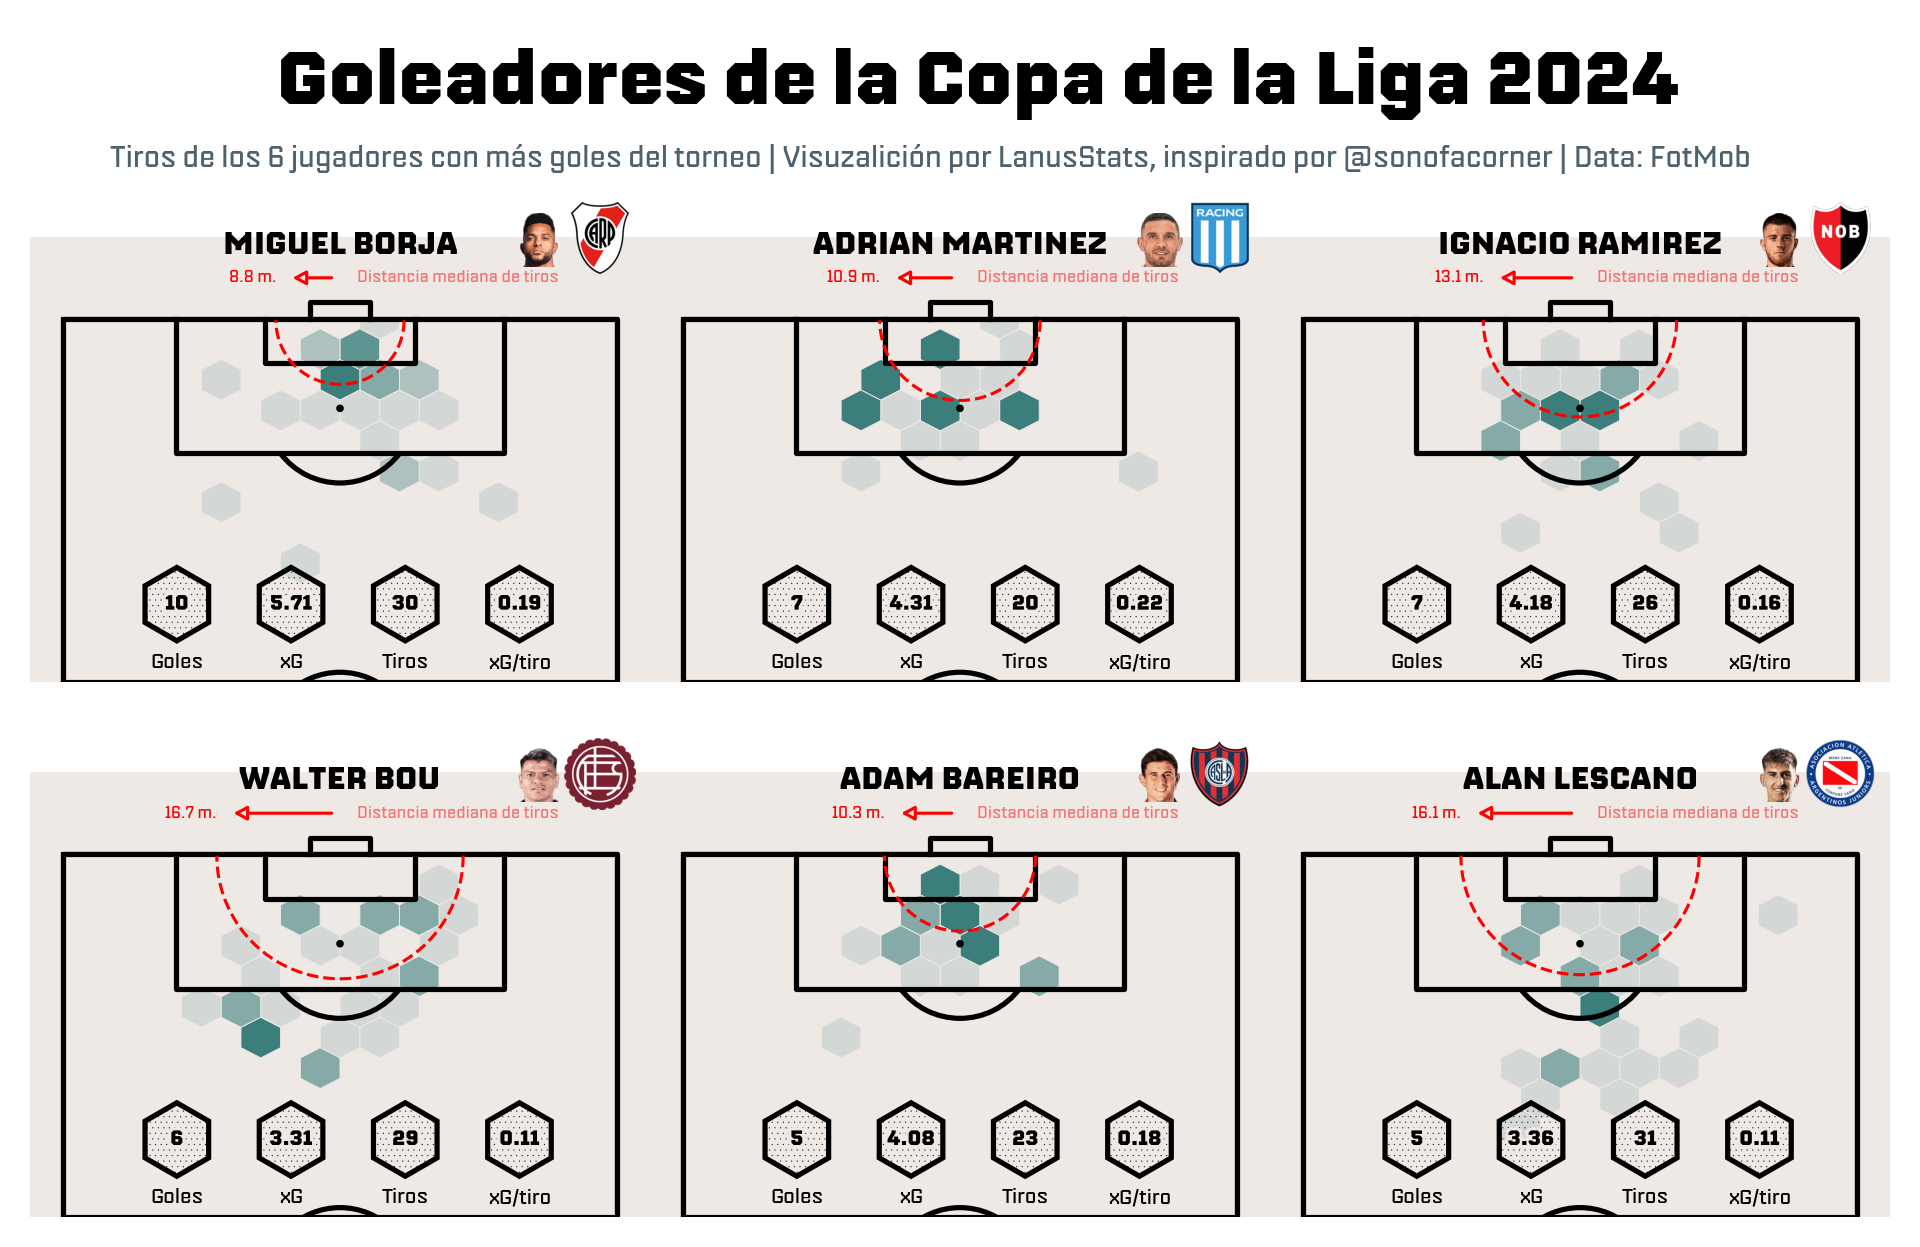

In [44]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(8,6), dpi=300)
fig.set_facecolor('white')
axs = np.array(axs)
plt.rcParams['hatch.linewidth'] = .02
for index, ax in enumerate(axs.reshape(-1)):
    plot_hexbin_shot(ax, ids_jugadores[index])

plt.subplots_adjust(wspace=0, hspace=-.35)

for index, ax in enumerate(axs.reshape(-1)):
    # -- Transformation functions
    DC_to_FC = ax.transData.transform
    FC_to_NFC = fig.transFigure.inverted().transform
    # -- Take data coordinates and transform them to normalized figure coordinates
    DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))
    ax_coords = DC_to_NFC((8,100))
    ax_size = 0.04
    image_ax = fig.add_axes(
        [ax_coords[0], ax_coords[1], ax_size, ax_size],
        fc='None'
    )
    fotmob_url = 'https://images.fotmob.com/image_resources/logo/teamlogo/'
    club_icon = Image.open(urllib.request.urlopen(f'{fotmob_url}{team_ids_jugadores[index]:.0f}.png'))
    image_ax.imshow(club_icon)
    image_ax.axis('off')

    ax_size = 0.03
    ax_coords = DC_to_NFC((14,100.5))
    image_ax = fig.add_axes(
        [ax_coords[0], ax_coords[1], ax_size, ax_size],
        fc='None'
    )
    fotmob_url = 'https://images.fotmob.com/image_resources/playerimages/'
    club_icon = Image.open(urllib.request.urlopen(f'{fotmob_url}{ids_jugadores[index]:.0f}.png'))
    image_ax.imshow(club_icon)
    image_ax.axis('off')

fig_text(
    x = 0.52, y = .84, 
    s = "Goleadores de la Copa de la Liga 2024",
    va = "bottom", ha = "center",
    fontsize = 18, color = "black", font = "Nippo", weight = "bold"
)
fig_text(
	x = 0.5, y = .81, 
    s = "Tiros de los 6 jugadores con más goles del torneo | Visuzalición por LanusStats, inspirado por @sonofacorner | Data: FotMob",
    # highlight_textprops=[{"weight": "bold", "color": "black"}],
	va = "bottom", ha = "center",
	fontsize = 7, color = "#4E616C", font = "Nippo"
)

plt.savefig('hexbins goleadores copaliga2024.png', dpi=300, bbox_inches='tight')